<h1 align="center">MACHINE LEARNING CLUSTERING MODEL FOR ACCIDENTAL DRUG RELATED DEATHS</h1>

After viewing and analyzing the data, we'll create a clustering Machine Learning model. We need to extract, clean, and process the data to find the best model for the clustering job.

## IMPORTING LIBRARIES

We'll import the necessary libraries for preprocessing, training and evaluating the Machine Learning clustering model:

In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import umap
import math
from scipy.stats import randint, uniform
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.model_selection import RandomizedSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from minisom import MiniSom
from time import time
import joblib
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

## EXTRACTING THE DATA

Let's read csv file for construct our model:

In [3]:
project_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(project_dir, "data", "processed")
path = os.path.join(data_dir, 'df_to_ml.csv')
data = pd.read_csv(path)
df= pd.DataFrame(data)

In [4]:
df.sample(3)

,Age,Sex,Residence County,Injury City,Injury County,Death City,Death County,Location,Heroin,Cocaine,Fentanyl,Oxycodone,Oxymorphone,Ethanol,Hydrocodone,Benzodiazepine,Methadone,Meth/Amphetamine,Amphet,Tramad,Hydromorphone,Morphine (Not Heroin),Xylazine,Gabapentin,Opiate NOS,Heroin/Morph/Codeine,Day,Resid_City_Coord_Lat,Resid_City_Coord_Lon,Injury_City_Coord_Lat,Injury_City_Coord_Lon,Death_City_Coord_Lat,Death_City_Coord_Lon
2087,21.0,Female,HARTFORD,WEST HARTFORD,UNKNOWN,WEST HARTFORD,HARTFORD,"House, Apartment, Residence or Decedent’s Home",Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,12.0,41.762008,-72.741807,41.762008,-72.741807,41.762008,-72.741807
11072,34.0,Male,TOLLAND,BOLTON,TOLLAND,UNKNOWN,UNKNOWN,Other or Unknown,N,Y,Y,N,N,N,N,N,N,N,N,N,N,N,Y,N,Y,N,27.0,41.769119,-72.433416,41.769119,-72.433416,41.573503,-72.738306
745,63.0,Male,UNKNOWN,MONTVILLE,NEW LONDON,MONTVILLE,UNKNOWN,"House, Apartment, Residence or Decedent’s Home",N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,9.0,41.453030,-72.136336,41.453030,-72.136336,41.453030,-72.136336


## DATA PREPROCESSING

Let's remove NaN values:

In [5]:
print(df.isna().sum())
print("-"*70)
df.shape

Age                        2
Sex                        0
Residence County           0
Injury City                0
Injury County              0
Death City                 0
Death County               0
Location                   0
Heroin                     0
Cocaine                    0
Fentanyl                   0
Oxycodone                  0
Oxymorphone                0
Ethanol                    0
Hydrocodone                0
Benzodiazepine             0
Methadone                  0
Meth/Amphetamine           0
Amphet                     0
Tramad                     0
Hydromorphone              0
Morphine (Not Heroin)      0
Xylazine                   0
Gabapentin                 0
Opiate NOS                 0
Heroin/Morph/Codeine       0
Day                        0
Resid_City_Coord_Lat     167
Resid_City_Coord_Lon     167
Injury_City_Coord_Lat    257
Injury_City_Coord_Lon    257
Death_City_Coord_Lat       1
Death_City_Coord_Lon       1
dtype: int64
------------------------------

(11981, 33)

In [6]:
df.dropna(axis= 0, inplace = True)
print(df.isna().sum())
print("-"*70)
print(df.shape)

Age                      0
Sex                      0
Residence County         0
Injury City              0
Injury County            0
Death City               0
Death County             0
Location                 0
Heroin                   0
Cocaine                  0
Fentanyl                 0
Oxycodone                0
Oxymorphone              0
Ethanol                  0
Hydrocodone              0
Benzodiazepine           0
Methadone                0
Meth/Amphetamine         0
Amphet                   0
Tramad                   0
Hydromorphone            0
Morphine (Not Heroin)    0
Xylazine                 0
Gabapentin               0
Opiate NOS               0
Heroin/Morph/Codeine     0
Day                      0
Resid_City_Coord_Lat     0
Resid_City_Coord_Lon     0
Injury_City_Coord_Lat    0
Injury_City_Coord_Lon    0
Death_City_Coord_Lat     0
Death_City_Coord_Lon     0
dtype: int64
----------------------------------------------------------------------
(11567, 33)


Now, we define functions to transform categorical variables to numerical, add these new columns, and evaluate them by silhouette score:

In [7]:
def label_encoder_function(dataframe, column):
    column_encoded = le.fit_transform(dataframe[column])
    return column_encoded

def add_nwe_column(dataframe, column):
    dataframe.loc[:,f'{column}_numeric']= label_encoder_function(dataframe, column)
    return dataframe

def clustering_score(model, X):
    try:
        labels = model.fit_predict(X)
        if isinstance(labels,DBSCAN):
            mask = labels != -1
            if np.sum(mask) > 1 :
                return silhouette_score(X[mask], labels[mask])
        else:
            return silhouette_score(X, labels)
    except Exception as e:
        return -1

Let's apply the transformation:

In [8]:
df.columns

Index(['Age', 'Sex', 'Residence County', 'Injury City', 'Injury County',
       'Death City', 'Death County', 'Location', 'Heroin', 'Cocaine',
       'Fentanyl', 'Oxycodone', 'Oxymorphone', 'Ethanol', 'Hydrocodone',
       'Benzodiazepine', 'Methadone', 'Meth/Amphetamine', 'Amphet', 'Tramad',
       'Hydromorphone', 'Morphine (Not Heroin)', 'Xylazine', 'Gabapentin',
       'Opiate NOS', 'Heroin/Morph/Codeine', 'Day', 'Resid_City_Coord_Lat',
       'Resid_City_Coord_Lon', 'Injury_City_Coord_Lat',
       'Injury_City_Coord_Lon', 'Death_City_Coord_Lat',
       'Death_City_Coord_Lon'],
      dtype='object')

In [9]:
le= LabelEncoder()

In [10]:
to_transform_numeric= ['Sex', 'Residence County','Injury City', 'Injury County','Death City', 'Death County', 'Location', 
                       'Heroin', 'Cocaine','Fentanyl', 'Oxycodone', 'Oxymorphone', 'Ethanol',
                       'Hydrocodone','Benzodiazepine', 'Methadone', 'Meth/Amphetamine', 'Amphet', 'Tramad','Hydromorphone',
                       'Morphine (Not Heroin)', 'Xylazine', 'Gabapentin','Opiate NOS', 'Heroin/Morph/Codeine']

for element in to_transform_numeric:
    add_nwe_column(df, element)

df.head(3)

,Age,Sex,Residence County,Injury City,Injury County,Death City,Death County,Location,Heroin,Cocaine,Fentanyl,Oxycodone,Oxymorphone,Ethanol,Hydrocodone,Benzodiazepine,Methadone,Meth/Amphetamine,Amphet,Tramad,Hydromorphone,Morphine (Not Heroin),Xylazine,Gabapentin,Opiate NOS,Heroin/Morph/Codeine,Day,Resid_City_Coord_Lat,Resid_City_Coord_Lon,Injury_City_Coord_Lat,Injury_City_Coord_Lon,Death_City_Coord_Lat,Death_City_Coord_Lon,Sex_numeric,Residence County_numeric,Injury City_numeric,Injury County_numeric,Death City_numeric,Death County_numeric,Location_numeric,Heroin_numeric,Cocaine_numeric,Fentanyl_numeric,Oxycodone_numeric,Oxymorphone_numeric,Ethanol_numeric,Hydrocodone_numeric,Benzodiazepine_numeric,Methadone_numeric,Meth/Amphetamine_numeric,Amphet_numeric,Tramad_numeric,Hydromorphone_numeric,Morphine (Not Heroin)_numeric,Xylazine_numeric,Gabapentin_numeric,Opiate NOS_numeric,Heroin/Morph/Codeine_numeric
0,37.0,Male,FAIRFIELD,STAMFORD,UNKNOWN,UNKNOWN,UNKNOWN,"House, Apartment, Residence or Decedent’s Home",N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,29.0,41.051924,-73.539475,41.051924,-73.539475,41.575155,-72.738288,1,29,206,11,196,7,10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,37.0,Male,NEW LONDON,NORWICH,UNKNOWN,NORWICH,NEW LONDON,"Hospital, Health Care Facility",Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,27.0,41.524304,-72.075821,41.524304,-72.075821,41.524304,-72.075821,1,61,148,11,133,5,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,28.0,Male,UNKNOWN,HEBRON,UNKNOWN,MARLBOROUGH,UNKNOWN,"Hospital, Health Care Facility",Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,24.0,41.658069,-72.366324,41.658069,-72.366324,41.632043,-72.461309,1,95,94,11,97,7,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
df_ml=df.drop(columns=to_transform_numeric)

In [12]:
df_ml.head(3)

,Age,Day,Resid_City_Coord_Lat,Resid_City_Coord_Lon,Injury_City_Coord_Lat,Injury_City_Coord_Lon,Death_City_Coord_Lat,Death_City_Coord_Lon,Sex_numeric,Residence County_numeric,Injury City_numeric,Injury County_numeric,Death City_numeric,Death County_numeric,Location_numeric,Heroin_numeric,Cocaine_numeric,Fentanyl_numeric,Oxycodone_numeric,Oxymorphone_numeric,Ethanol_numeric,Hydrocodone_numeric,Benzodiazepine_numeric,Methadone_numeric,Meth/Amphetamine_numeric,Amphet_numeric,Tramad_numeric,Hydromorphone_numeric,Morphine (Not Heroin)_numeric,Xylazine_numeric,Gabapentin_numeric,Opiate NOS_numeric,Heroin/Morph/Codeine_numeric
0,37.0,29.0,41.051924,-73.539475,41.051924,-73.539475,41.575155,-72.738288,1,29,206,11,196,7,10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,37.0,27.0,41.524304,-72.075821,41.524304,-72.075821,41.524304,-72.075821,1,61,148,11,133,5,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,28.0,24.0,41.658069,-72.366324,41.658069,-72.366324,41.632043,-72.461309,1,95,94,11,97,7,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
df_ml.shape

(11567, 33)

## GENERATING A CLUSTERING MACHINE LEARNING MODEL

We'll create a function that reduces the dimensionality, trains multiple models, selects the best model using various evaluation parameters, and saves it:

In [24]:
def plot_som_hits(som, X):
    
    x_dim, y_dim = som._weights.shape[:2]  
    hits = np.zeros((x_dim, y_dim))

    win_map = som.win_map(X)  
    for (i, j), val in win_map.items():
        hits[i, j] = len(val)  

    plt.figure(figsize=(6, 6))
    plt.imshow(hits, cmap="coolwarm", origin="upper")
    plt.colorbar(label="Number of samples")
    plt.title("Hit Map (Frequency per Neuron)")
    plt.show()

In [45]:
def scale_train_and_evaluate_models(df, models, param_distributions, n_iter):

    df.select_dtypes(include=[np.number]).columns.tolist()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)

    pca = PCA(n_components=2)
    pca_embedding = pca.fit_transform(X_scaled)

    umap_reducer = umap.UMAP(n_components=2, metric='euclidean', random_state=42)
    umap_embedding = umap_reducer.fit_transform(X_scaled)


    num_neurons = int(5 * math.sqrt(len(df)))  
    x_dim = int(math.sqrt(num_neurons))  
    y_dim = int(num_neurons / x_dim)

    som = MiniSom(x=x_dim, y=y_dim, input_len=X_scaled.shape[1], sigma=0.5, learning_rate=0.3, random_seed=42)  
    som.train_random(X_scaled, 100)  
    som_embedding = np.array([som.winner(x) for x in X_scaled]) 

    best_model_dict = {}

    for name, model in models.items():
        print(f"\n🔹 Training and Evaluating {name}:")
        start_time = time()

        if name == "DBSCAN":
            data = pca_embedding
        elif name == "SOM_Compatible_Clustering":
            data = som_embedding  
        else:
            data = umap_embedding

        random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions[name],
                                           n_iter=n_iter, cv=5, scoring=clustering_score, n_jobs=5)
        random_search.fit(data)

        best_model = random_search.best_estimator_
        best_params = random_search.best_params_
        labels = best_model.fit_predict(data)
        score = clustering_score(best_model, data)
        best_model_name= name

        print(f"{name}: Score = {score:.4f}")
        end_time = time()
        print(f"Training time for {name}: {end_time - start_time:.2f} seconds")
              
        best_model_dict[name] = {'model': best_model, 'params': best_params, 'labels': labels, 'score': score}

    best_model_info = best_model_dict[max(best_model_dict, key=lambda x: best_model_dict[x]['score'])]

    print(f"\n🏆 Best model: {best_model_info['model']}, Silhouette Score: {best_model_info['score']:.4f}")

    project_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    model_dir = os.path.join(project_dir, "models")
    os.makedirs(model_dir, exist_ok=True)

    best_model_path = os.path.join(model_dir, "best_clustering_model.pkl")
    joblib.dump(best_model_info['model'], best_model_path)

    if best_model_name =="SOM_Compatible_Clustering":
        plot_som_hits(som, X_scaled)

Now, let's define the models and their hyperparameter search spaces:

In [34]:
param_distributions = {
    
    'K-Means': {
        'n_clusters' : randint(1,50),
        'init': ['k-means++', 'random'],
        'n_init' : randint(1,15),
        'max_iter' : randint(100,300),
               },
    'DBSCAN': {
        'eps': uniform(0.1, 5),
        'min_samples': randint(5, 15),
        'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': randint(10, 40),
               },

    'Agglomerative':{
        'n_clusters' : randint(5, 20),
        'metric': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
        'linkage': ['ward', 'complete', 'average', 'single'],
                    },


    'Gaussian Mixture':{
        'n_components': randint(2, 15),
        'covariance_type': ['full', 'tied', 'diag', 'spherical'],
        'tol': uniform(0.1, 1),
        'reg_covar': uniform(0.01, 1),
        'max_iter': randint(100, 300),
        'n_init': randint(1, 10),
        'init_params':['kmeans', 'k-means++', 'random', 'random_from_data']
                        },

    'SOM_Compatible_Clustering': {
        'eps': uniform(0.1, 5),
        'min_samples': randint(5, 15),
        'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': randint(10, 40),
               }
}

models = {
    'K-Means': KMeans(),
    'DBSCAN': DBSCAN(),
    'Agglomerative': AgglomerativeClustering(),
    'Gaussian Mixture': GaussianMixture(),
    'SOM_Compatible_Clustering': DBSCAN()
}

Use the defined function

In [35]:
df_ml_sample=df_ml.sample(round(df_ml.shape[0]*0.25))

Sample size: 2892
Number of iteration: 10

🔹 Training and Evaluating K-Means:
K-Means: Score = 0.6379
Training time for K-Means: 2.66 seconds

🔹 Training and Evaluating DBSCAN:
DBSCAN: Score = 0.7029
Training time for DBSCAN: 2.16 seconds

🔹 Training and Evaluating Agglomerative:
Agglomerative: Score = 0.5883
Training time for Agglomerative: 2.64 seconds

🔹 Training and Evaluating Gaussian Mixture:
Gaussian Mixture: Score = 0.5986
Training time for Gaussian Mixture: 1.53 seconds

🔹 Training and Evaluating SOM_Compatible_Clustering:
SOM_Compatible_Clustering: Score = 0.8700
Training time for SOM_Compatible_Clustering: 1.11 seconds

🏆 Best model: DBSCAN(algorithm='ball_tree', eps=0.8924375029794422, leaf_size=38), Silhouette Score: 0.8700


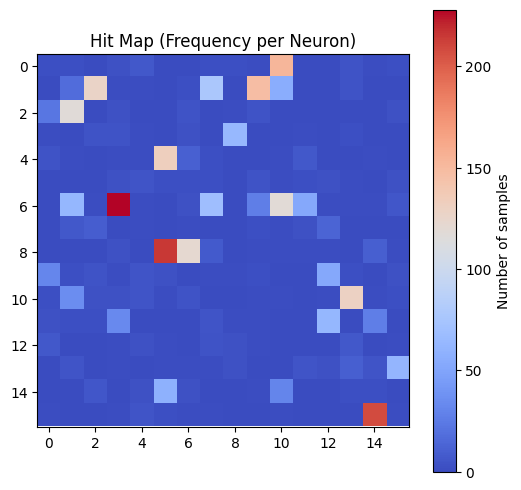

In [46]:
n_iter=10

print(f"Sample size: {df_ml_sample.shape[0]}")
print(f"Number of iteration: {n_iter}")

scale_train_and_evaluate_models(df_ml_sample, models, param_distributions, n_iter)

We see that DBSCAN with SOM has the best score, so we apply the defined function only to this model with the expanded data and increased iterations, which helps avoid overfitting:

In [47]:
param_distributions_2 = { 

    'SOM_Compatible_Clustering': {
        'eps': uniform(0.1, 5),
        'min_samples': randint(5, 15),
        'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': randint(10, 40),
               }
    }



final_model = {'SOM_Compatible_Clustering': DBSCAN()}

Data size: 11567
Number of iteration: 100

🔹 Training and Evaluating SOM_Compatible_Clustering:
SOM_Compatible_Clustering: Score = 0.9195
Training time for SOM_Compatible_Clustering: 77.09 seconds

🏆 Best model: DBSCAN(algorithm='kd_tree', eps=0.6534751943867166, leaf_size=17), Silhouette Score: 0.9195


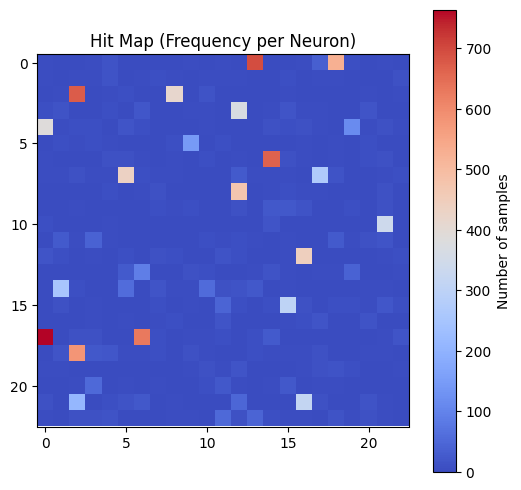

In [48]:
n_iter_2=100

print(f"Data size: {df_ml.shape[0]}")
print(f"Number of iteration: {n_iter_2}")

scale_train_and_evaluate_models(df_ml, final_model, param_distributions_2, n_iter_2)

We finally get a model with the best score and reduced overfitting.